In [1]:
#hannah regression

#### Data management

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels as sm
from statsmodels import *
import scipy.stats as stats
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
import statsmodels
import holidays
from datetime import timedelta
import numpy as np

In [17]:
train = pd.read_csv(r"D:\Summer Practicum\1_Data\training_airlines.csv", low_memory = False)
train2=train.copy()
test = pd.read_csv(r"D:\Summer Practicum\1_Data\testing_airlines.csv", low_memory = False)
test2=test.copy()

In [4]:
airports_list = ['ATL',
 'DEN',
 'DFW',
 'LAS',
 'ORD',
 'LAX',
 'MCO',
 'PHX',
 'SEA',
 'CLT',
 'BOS',
 'EWR',
 'SFO',
 'JFK',
 'IAH',
 'LGA',
 'MIA',
 'BWI',
 'FLL',
 'DTW',
 'MDW',
 'AUS',
 'SAN',
 'MSP',
 'BNA',
 'SLC',
 'TPA',
 'DCA',
 'DAL',
 'PHL',
 'HNL',
 'STL',
 'HOU',
 'SMF',
 'SJC',
 'MSY',
 'OAK',
 'PDX',
 'SNA',
 'RDU',
 'IAD',
 'MCI',
 'SAT',
 'RSW',
 'OGG',
 'SJU',
 'BUR',
 'CLE',
 'PBI',
 'IND',
 'PIT',
 'ONT',
 'CMH',
 'JAX',
 'CVG',
 'BDL',
 'ANC',
 'CHS',
 'KOA',
 'ABQ',
 'MKE',
 'LIH',
 'OMA',
 'RNO']

In [18]:
total_flights = train.shape[0]
origin_counts = train['Origin'].value_counts().reset_index()
origin_counts.columns = ['Origin', "Flight_Count"]
origin_counts['Proportion'] = origin_counts['Flight_Count'] / total_flights

total_flights2 = test.shape[0]
origin_counts2 = test['Origin'].value_counts().reset_index()
origin_counts2.columns = ['Origin', "Flight_Count"]
origin_counts2['Proportion'] = origin_counts2['Flight_Count'] / total_flights2


def classify_hub(proportion):
    if proportion >= 0.01:
        return 'Large Hub'
    elif 0.0025 <= proportion < 0.01:
        return "Medium Hub"
    elif 0.0005 <= proportion < 0.0025:
        return "Small Hub"
    elif proportion < 0.0005:
        return "Non Hub"
    
origin_counts["Size_Class"] = origin_counts["Proportion"].apply(classify_hub)
train2 = train2.merge(origin_counts[['Origin', "Size_Class"]], on="Origin", how='left')

origin_counts2["Size_Class"] = origin_counts2["Proportion"].apply(classify_hub)
test2 = test2.merge(origin_counts2[['Origin', "Size_Class"]], on="Origin", how='left')

In [19]:
train2['FlightDate'] = pd.to_datetime(train2['FlightDate'])
train2.columns = train2.columns.str.replace(' ','')

test2['FlightDate'] = pd.to_datetime(test2['FlightDate'])
test2.columns = test2.columns.str.replace(' ','')

us_holidays = holidays.US(years=range(train2['FlightDate'].min().year,train2['FlightDate'].max().year +1))
holiday_dates = {date for date, name in us_holidays.items()}

train2['Is_Holiday'] = train2['FlightDate'].dt.date.isin(holiday_dates)
test2['Is_Holiday'] = test2['FlightDate'].dt.date.isin(holiday_dates)

holiday_week = set()
for holiday in holiday_dates:
        # Add the holiday date itself
        holiday_week.add(holiday)
        
        # Add the 'window_days' before and after the holiday
        for i in range(1, 3 + 1):
            holiday_week.add(holiday + timedelta(days=i))
            holiday_week.add(holiday - timedelta(days=i))

# Create the new 'Is_Holiday_Window' boolean column
train2['Is_Holiday_Week'] = train2['FlightDate'].dt.date.isin(holiday_week)
test2['Is_Holiday_Week'] = test2['FlightDate'].dt.date.isin(holiday_week)

In [20]:
#departure hour

def extract_hour(time_value):
    if pd.isna(time_value):
        return None
    time_str = str(int(time_value))

    if len(time_str) == 3:
        return int(time_str[0])
    elif len(time_str) == 4:
        return int(time_str[:2])
    else:
        return None

# Apply the function to the entire column
train2['hour_of_day'] = train2['DepTime'].apply(extract_hour)
test2['hour_of_day'] = test2['DepTime'].apply(extract_hour)


In [21]:
def classify_time(hour):
    if hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 < hour <= 24:
        return "Night"
    
train2["hour_group"] = train2["hour_of_day"].apply(classify_time)

test2["hour_group"] = test2["hour_of_day"].apply(classify_time)

In [22]:
def state_to_region(state):
    West = ["WA", "MT", "ID", "WY", "OR", "CA", "NV", "UT", "CO", "AZ", "NM", "AK", "HI"]
    South = ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", "FL", "GA", "SC", "NC", "VA", "MD", "DE"]
    Northeast = ["PA", "NJ", "NY", "CT", "MA", "RI", "ME", "NH", "VT"]
    Midwest = ["ND", "SD", "NE", "KS", "MO", "IA", "MN", "WI", "IL", "IN", "OH", "MI"]
    if state in West:
        return "West"
    elif state in South:
        return "South"
    elif state in Northeast:
        return "Northeast"
    elif state in Midwest:
        return "Midwest"
    
train2["Region"] = train2["OriginState"].map(state_to_region)
test2["Region"] = test2["OriginState"].map(state_to_region)

In [23]:
train2.columns = train2.columns.str.replace(' ', '')
train2.rename(columns={'Operating_Airline ': 'Operating_Airline'}, inplace=True)
train2.dropna(subset=['ArrDel15', 'Operating_Airline', 'DistanceGroup', 'Is_Holiday_Week', 'DayOfWeek', 'hour_of_day'], inplace=True)
train2.dropna(subset=['Region'], inplace=True)

test2.columns = test2.columns.str.replace(' ', '')
test2.rename(columns={'Operating_Airline ': 'Operating_Airline'}, inplace=True)
test2.dropna(subset=['ArrDel15', 'Operating_Airline', 'DistanceGroup', 'Is_Holiday_Week', 'DayOfWeek', 'hour_of_day'], inplace=True)
test2.dropna(subset=['Region'], inplace=True)

In [27]:
train2.to_csv('D:/Summer Practicum/1_Data/training_regression3.csv', index=False)
#test2.to_csv('D:/Summer Practicum/1_Data/testing_regression.csv', index=False)

#### read in new data

In [3]:
train2 = pd.read_csv('D:/Summer Practicum/1_Data/training_regression3.csv')
#test2 = pd.read_csv('D:/Summer Practicum/1_Data/testing_regression.csv')

#### Overall logit model

In [4]:
#logistic regression
model_logit = smf.logit("ArrDel15 ~ C(Operating_Airline, Treatment('AS')) + C(DistanceGroup) + C(Is_Holiday) + C(DayOfWeek) + C(hour_of_day) + C(Region, Treatment('South')) + C(Size_Class)", data=train2).fit()
model_logit.summary()

Optimization terminated successfully.
         Current function value: 0.496898
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:              3313906
Model:                          Logit   Df Residuals:                  3313850
Method:                           MLE   Df Model:                           55
Date:                Tue, 29 Jul 2025   Pseudo R-squ.:                 0.07203
Time:                        21:35:40   Log-Likelihood:            -1.6467e+06
converged:                       True   LL-Null:                   -1.7745e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.6266      0.029     21.326      0.000       0.569       0.684
C(Operating_Airline, Treatment('AS'))[T.AA]     0.1463      0.007     19.514      0.000       0.132       0.161
C(Operating_Airline, Treatment('AS'))[T.B6]     0.4245      0.009     48.021      0.000       0.407       0.442
C(Operating_Airline, Treatment('AS'))[T.DL]    -0.3169      0.008    -41.485      0.000      -0.332      -0.302
C(Operating_Airline, Treatment('AS'))[T.F9]     0.4093      0.010     42.052      0.000       0.390       0.428
C(Operating_Airline, Treatment('AS'))[T.G4]     0.5827      0.011     53.471      0.000       0.561       0.604
C(Operating_Airline, Treatment('AS'))[T.HA]     0.5641      0.013     45.012      0.000       0.540       0.589
C(Operating_Airline, Treatment('AS'))[T.NK]     0.1717      0.009     18.922      0.000       0.154       0.190
C(Operating_Airline, Treatment('AS'))[T.UA]    -0.1087      0.008    -14.173      0.000      -0.124      -0.094
C(Operating_Airline, Treatment('AS'))[T.WN]     0.1939      0.007     26.902      0.000       0.180       0.208
C(DistanceGroup)[T.2]                           0.0022      0.006      0.363      0.717      -0.010       0.014
C(DistanceGroup)[T.3]                           0.0991      0.006     16.399      0.000       0.087       0.111
C(DistanceGroup)[T.4]                           0.1744      0.006     28.981      0.000       0.163       0.186
C(DistanceGroup)[T.5]                           0.2635      0.006     42.134      0.000       0.251       0.276
C(DistanceGroup)[T.6]                           0.1697      0.008     21.896      0.000       0.155       0.185
C(DistanceGroup)[T.7]                           0.1678      0.008     21.323      0.000       0.152       0.183
C(DistanceGroup)[T.8]                           0.0572      0.010      5.675      0.000       0.037       0.077
C(DistanceGroup)[T.9]                          -0.0005      0.011     -0.045      0.964      -0.022       0.021
C(DistanceGroup)[T.10]                         -0.0015      0.009     -0.171      0.864      -0.019       0.016
C(DistanceGroup)[T.11]                         -0.0264      0.010     -2.724      0.006      -0.045      -0.007
C(Is_Holiday)[T.True]                           0.0458      0.007      6.107      0.000       0.031       0.060
C(DayOfWeek)[T.2]                              -0.1563      0.005    -28.965      0.000      -0.167      -0.146
C(DayOfWeek)[T.3]                              -0.0305      0.005     -5.748      0.000      -0.041      -0.020
C(DayOfWeek)[T.4]                               0.0868      0.005     16.873      0.000       0.077       0.097
C(DayOfWeek)[T.5]                               0.1908      0.005     37.843      0.000       0.181       0.201
C(DayOfWeek)[T.6]                               0.0488      0.005      9.063      0.000       0.038      

In [25]:
from sklearn.metrics import classification_report

y_pred_prob = model_logit.predict(train2)

y_pred_class = (y_pred_prob > 0.2292).astype(int)

# 3. Get the true (actual) values from your dataset
y_true = train2['ArrDel15']

report = classification_report(y_true, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70   2562072
         1.0       0.32      0.68      0.44    751834

    accuracy                           0.61   3313906
   macro avg       0.59      0.63      0.57   3313906
weighted avg       0.74      0.61      0.64   3313906



In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import sklearn
y_true = test2['ArrDel15']
y_pred_prob = model_logit.predict(test2)

# --- 4. Calculate AUC-ROC ---
auc_roc = roc_auc_score(y_true, y_pred_prob)
print(f"Concordance for Logistic Regression: {auc_roc:.4f}")


Concordance for Logistic Regression: 0.6826


In [45]:
odds_ratio = np.exp(model_logit.params)
print(odds_ratio)

odds_ratio.to_csv('D:/Summer Practicum/3_Exports/odds_ratios_as_odds.csv')

Intercept                                      1.871330
C(Operating_Airline, Treatment('AS'))[T.AA]    1.157535
C(Operating_Airline, Treatment('AS'))[T.B6]    1.528817
C(Operating_Airline, Treatment('AS'))[T.DL]    0.728424
C(Operating_Airline, Treatment('AS'))[T.F9]    1.505732
C(Operating_Airline, Treatment('AS'))[T.G4]    1.790949
C(Operating_Airline, Treatment('AS'))[T.HA]    1.757815
C(Operating_Airline, Treatment('AS'))[T.NK]    1.187351
C(Operating_Airline, Treatment('AS'))[T.UA]    0.897006
C(Operating_Airline, Treatment('AS'))[T.WN]    1.214024
C(DistanceGroup)[T.2]                          1.002199
C(DistanceGroup)[T.3]                          1.104134
C(DistanceGroup)[T.4]                          1.190525
C(DistanceGroup)[T.5]                          1.301417
C(DistanceGroup)[T.6]                          1.185005
C(DistanceGroup)[T.7]                          1.182692
C(DistanceGroup)[T.8]                          1.058873
C(DistanceGroup)[T.9]                          0

In [46]:
odds_ratio_percent = 100*(np.exp(model_logit.params) - 1)
print(odds_ratio_percent)

odds_ratio_percent.to_csv('D:/Summer Practicum/3_Exports/odds_ratios_as_percentages.csv')

Intercept                                      87.133030
C(Operating_Airline, Treatment('AS'))[T.AA]    15.753487
C(Operating_Airline, Treatment('AS'))[T.B6]    52.881684
C(Operating_Airline, Treatment('AS'))[T.DL]   -27.157594
C(Operating_Airline, Treatment('AS'))[T.F9]    50.573156
C(Operating_Airline, Treatment('AS'))[T.G4]    79.094949
C(Operating_Airline, Treatment('AS'))[T.HA]    75.781494
C(Operating_Airline, Treatment('AS'))[T.NK]    18.735145
C(Operating_Airline, Treatment('AS'))[T.UA]   -10.299352
C(Operating_Airline, Treatment('AS'))[T.WN]    21.402407
C(DistanceGroup)[T.2]                           0.219873
C(DistanceGroup)[T.3]                          10.413358
C(DistanceGroup)[T.4]                          19.052499
C(DistanceGroup)[T.5]                          30.141714
C(DistanceGroup)[T.6]                          18.500482
C(DistanceGroup)[T.7]                          18.269158
C(DistanceGroup)[T.8]                           5.887291
C(DistanceGroup)[T.9]          

C:\Users\hrenck\AppData\Local\Temp\5\ipykernel_35496\3522176552.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
c:\ProgramData\anaconda3\envs\hannah_environment\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


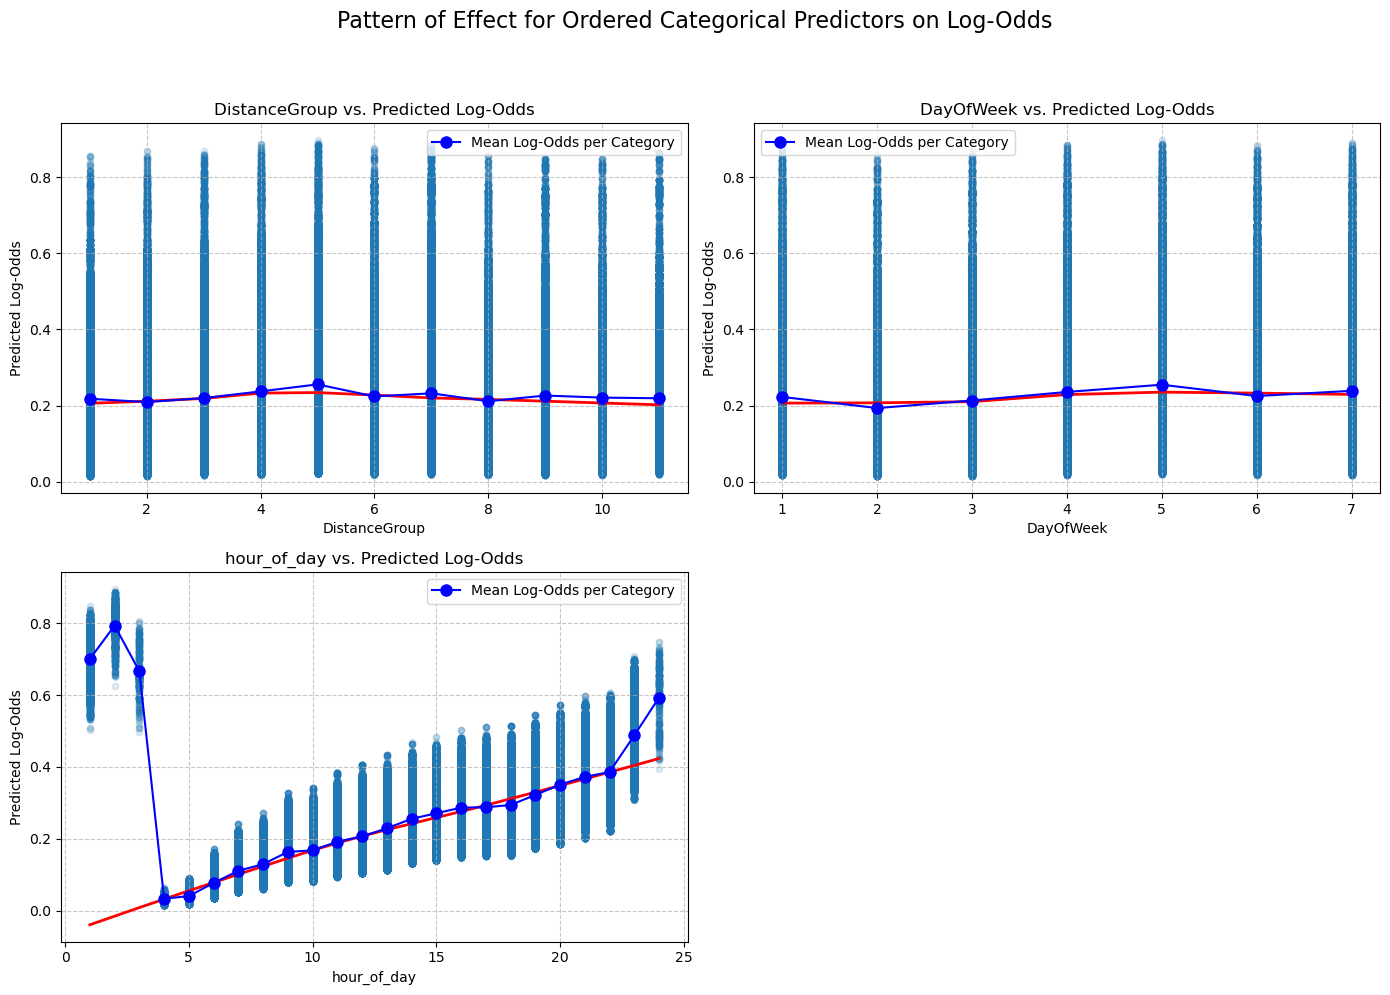

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
X_const = model_logit.model.exog

predicted_log_odds = model_logit.predict(X_const, transform=False)


ordered_categorical_vars = ['DistanceGroup', 'DayOfWeek', 'hour_of_day']
ordered_categorical_vars = [v for v in ordered_categorical_vars if v in train2.columns]

if ordered_categorical_vars:
    n_vars = len(ordered_categorical_vars)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 7, n_rows * 5))
    plt.suptitle('Pattern of Effect for Ordered Categorical Predictors on Log-Odds', fontsize=16, y=1.02)

    # Create a temporary DataFrame to hold the predicted log-odds alongside your features
    # This is the most robust way to ensure the column exists for groupby.
    plot_df = train2.copy()
    plot_df['predicted_log_odds_col'] = predicted_log_odds

    for i, var in enumerate(ordered_categorical_vars):
        ax = plt.subplot(n_rows, n_cols, i + 1)

        # Use seaborn.regplot with lowess=True
        sns.regplot(x=plot_df[var], y=plot_df['predicted_log_odds_col'], # Use the new column name
                    lowess=True,
                    scatter_kws={'alpha': 0.15, 's': 20},
                    line_kws={'color': 'red', 'linestyle': '-', 'linewidth': 2},
                    ax=ax)

        # Get the mean log-odds for each specific category
        mean_log_odds_by_cat = plot_df.groupby(var)['predicted_log_odds_col'].mean().reset_index() # Use the new column name
        ax.plot(mean_log_odds_by_cat[var], mean_log_odds_by_cat['predicted_log_odds_col'], # Use the new column name
                'o-', markersize=8, color='blue', label='Mean Log-Odds per Category')

        ax.set_title(f'{var} vs. Predicted Log-Odds')
        ax.set_xlabel(var)
        ax.set_ylabel('Predicted Log-Odds')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("No relevant ordered categorical variables found for plotting.")




#### model and graph for airline

In [49]:
model_logit_airline = smf.logit("ArrDel15 ~ C(Operating_Airline, Treatment('AS'))", data=train2).fit()
model_logit_airline.summary()

Optimization terminated successfully.
         Current function value: 0.530436
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:              3313906
Model:                          Logit   Df Residuals:                  3313896
Method:                           MLE   Df Model:                            9
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                0.009400
Time:                        13:21:22   Log-Likelihood:            -1.7578e+06
converged:                       True   LL-Null:                   -1.7745e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -1.3268      0.006   -215.339      0.000      -1.339      -1.315
C(Operating_Airline, Treatment('AS'))[T.AA]     0.1648      0.007     24.016      0.000       0.151       0.178
C(Operating_Airline, Treatment('AS'))[T.B6]     0.5295      0.008     66.230      0.000       0.514       0.545
C(Operating_Airline, Treatment('AS'))[T.DL]    -0.2816      0.007    -40.020      0.000      -0.295      -0.268
C(Operating_Airline, Treatment('AS'))[T.F9]     0.5470      0.009     60.146      0.000       0.529       0.565
C(Operating_Airline, Treatment('AS'))[T.G4]     0.6114      0.010     62.412      0.000       0.592       0.631
C(Operating_Airline, Treatment('AS'))[T.HA]     0.3146      0.012     27.107      0.000       0.292       0.337
C(Operating_Airline, Treatment('AS'))[T.NK]     0.2422      0.008     28.709      0.000       0.226       0.259
C(Operating_Airline, Treatment('AS'))[T.UA]    -0.0791      0.007    -10.952      0.000      -0.093      -0.065
C(Operating_Airline, Treatment('AS'))[T.WN]     0.1521      0.007     22.915      0.000       0.139       0.165
===============================================================================================================
"""

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import sklearn
y_true_airline = test2['ArrDel15']
y_pred_prob_airline = model_logit_airline.predict(test2)

# --- 4. Calculate AUC-ROC ---
auc_roc_airline = roc_auc_score(y_true_airline, y_pred_prob_airline)
print(f"Concordance for Logistic Regression: {auc_roc_airline:.4f}")

Concordance for Logistic Regression: 0.5633


In [4]:
odds_ratio_airline = np.exp(model_logit_airline.params)
print(odds_ratio_airline)

Intercept                                      0.265334
C(Operating_Airline, Treatment('AS'))[T.AA]    1.179210
C(Operating_Airline, Treatment('AS'))[T.B6]    1.698149
C(Operating_Airline, Treatment('AS'))[T.DL]    0.754550
C(Operating_Airline, Treatment('AS'))[T.F9]    1.728097
C(Operating_Airline, Treatment('AS'))[T.G4]    1.842965
C(Operating_Airline, Treatment('AS'))[T.HA]    1.369754
C(Operating_Airline, Treatment('AS'))[T.NK]    1.274012
C(Operating_Airline, Treatment('AS'))[T.UA]    0.923968
C(Operating_Airline, Treatment('AS'))[T.WN]    1.164266
dtype: float64


In [50]:
odds_ratio_percent_airline = 100*(np.exp(model_logit_airline.params) - 1)
print(odds_ratio_percent_airline)

Intercept                                     -73.466642
C(Operating_Airline, Treatment('AS'))[T.AA]    17.920981
C(Operating_Airline, Treatment('AS'))[T.B6]    69.814867
C(Operating_Airline, Treatment('AS'))[T.DL]   -24.544969
C(Operating_Airline, Treatment('AS'))[T.F9]    72.809679
C(Operating_Airline, Treatment('AS'))[T.G4]    84.296550
C(Operating_Airline, Treatment('AS'))[T.HA]    36.975407
C(Operating_Airline, Treatment('AS'))[T.NK]    27.401218
C(Operating_Airline, Treatment('AS'))[T.UA]    -7.603218
C(Operating_Airline, Treatment('AS'))[T.WN]    16.426599
dtype: float64


In [16]:
odds_ratios_airlines = model_logit_airline.params.apply(lambda x: np.exp(x))
conf_int_airlines = model_logit_airline.conf_int().apply(lambda x: np.exp(x))

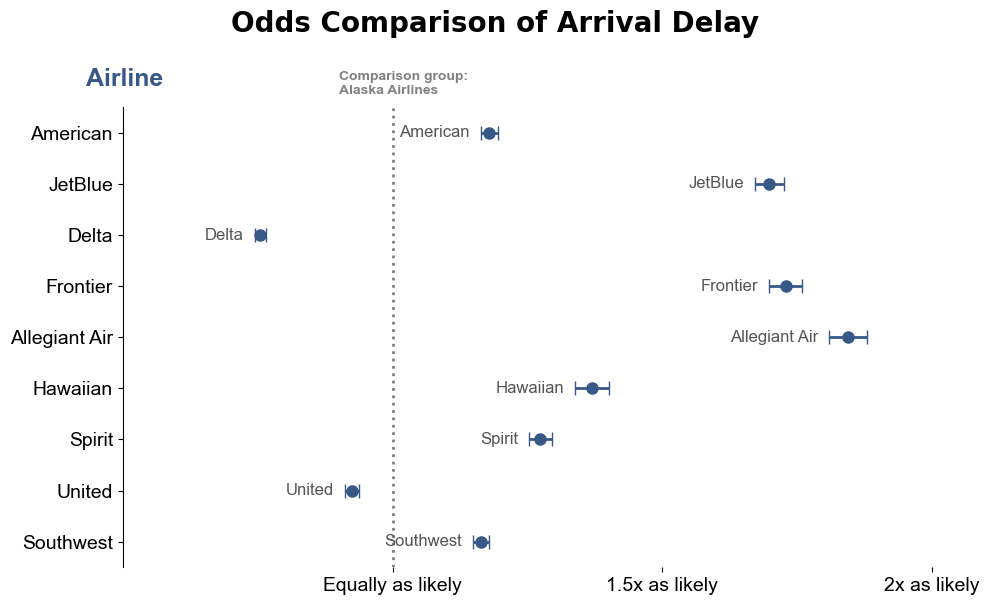

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

airline_graph_data = {
    'group': ['Intercept','American','JetBlue','Delta','Frontier','Allegiant Air','Hawaiian','Spirit','United','Southwest'],
    'odds_ratio': odds_ratios_airlines,
    'lower_ci': conf_int_airlines[0],
    'upper_ci': conf_int_airlines[1]
}
airline_graph_df = pd.DataFrame(airline_graph_data)
airline_graph_df = airline_graph_df[airline_graph_df['group'] != 'Intercept']
airline_graph_df = airline_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=airline_graph_df['odds_ratio'],
    y=airline_graph_df.index,
    xerr=[airline_graph_df['odds_ratio'] - airline_graph_df['lower_ci'], airline_graph_df['upper_ci'] - airline_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(airline_graph_df.index)
ax.set_yticklabels(airline_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(airline_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = airline_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = airline_graph_df.index[i]
    # The text itself
    label = airline_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Airline', x=-.045, y=1.028, loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(.9, len(airline_graph_df)-.3, 'Comparison group:\nAlaska Airlines', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(airline_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(airline_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/allairlines_delay')
plt.show()


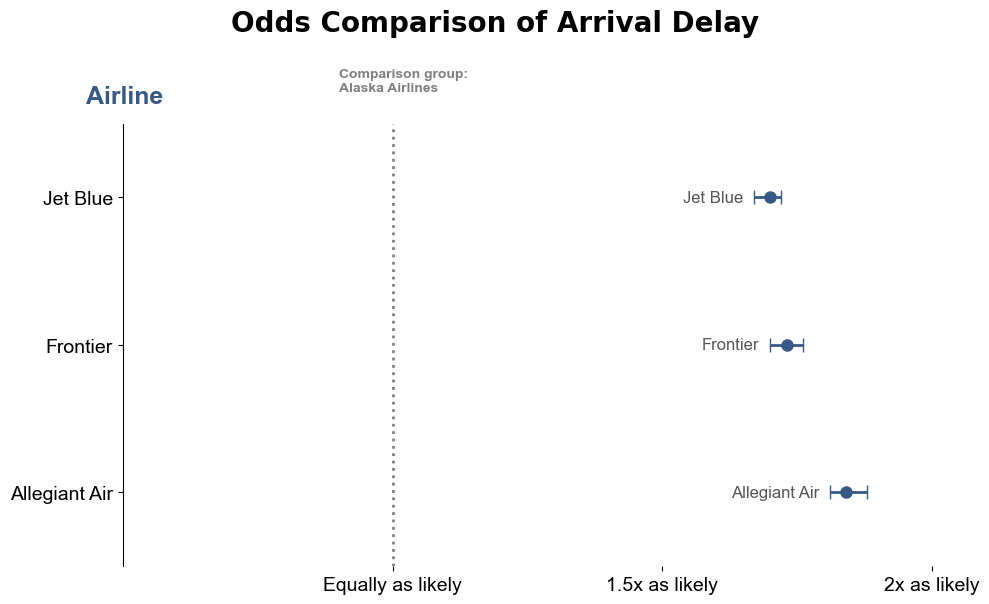

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

airline_graph_data = {
    'group': ['Jet Blue','Frontier','Allegiant Air'],
    'odds_ratio': [1.70, 1.73, 1.84],
    'lower_ci': [1.67, 1.70, 1.81],
    'upper_ci': [1.72, 1.76, 1.88]
}
airline_graph_df = pd.DataFrame(airline_graph_data)
airline_graph_df = airline_graph_df[airline_graph_df['group'] != 'Intercept']
airline_graph_df = airline_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=airline_graph_df['odds_ratio'],
    y=airline_graph_df.index,
    xerr=[airline_graph_df['odds_ratio'] - airline_graph_df['lower_ci'], airline_graph_df['upper_ci'] - airline_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(airline_graph_df.index)
ax.set_yticklabels(airline_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(airline_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = airline_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = airline_graph_df.index[i]
    # The text itself
    label = airline_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Airline', x=-.045, y=1.028, loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(.9, len(airline_graph_df)-.3, 'Comparison group:\nAlaska Airlines', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(airline_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(airline_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/3airlines_delay')
plt.show()

#### model and graph for region

In [51]:
model_logit_region = smf.logit("ArrDel15 ~ C(Region, Treatment('Midwest'))", data=train2).fit()
model_logit_region.summary()

Optimization terminated successfully.
         Current function value: 0.535294
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:              3313906
Model:                          Logit   Df Residuals:                  3313902
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:               0.0003287
Time:                        13:23:05   Log-Likelihood:            -1.7739e+06
converged:                       True   LL-Null:                   -1.7745e+06
Covariance Type:            nonrobust   LLR p-value:                1.277e-252
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.2791      0.004   -347.328      0.000      -1.286      -1.272
C(Region, Treatment('Midwest'))[T.Northeast]     0.1534      0.005     29.442      0.000       0.143       0.164
C(Region, Treatment('Midwest'))[T.South]         0.0651      0.004     15.475      0.000       0.057       0.073
C(Region, Treatment('Midwest'))[T.West]          0.0214      0.004      4.939      0.000       0.013       0.030
================================================================================================================
"""

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import sklearn
y_true_region = test2['ArrDel15']
y_pred_prob_region = model_logit_airline.predict(test2)

# --- 4. Calculate AUC-ROC ---
auc_roc_region = roc_auc_score(y_true_region, y_pred_prob_region)
print(f"Concordance for Logistic Regression: {auc_roc_region:.4f}")

Concordance for Logistic Regression: 0.5633


In [56]:
odds_ratio_region = np.exp(model_logit_region.params)
print(odds_ratio_region)

Intercept                                       0.324438
C(Region, Treatment('Northeast'))[T.Midwest]    0.857759
C(Region, Treatment('Northeast'))[T.South]      0.915461
C(Region, Treatment('Northeast'))[T.West]       0.876309
dtype: float64


In [ ]:
odds_ratio_percent_region = 100*(np.exp(model_logit_region.params) - 1)
print(odds_ratio_percent_region)

In [8]:
odds_ratios_regions = model_logit_region.params.apply(lambda x: np.exp(x))
conf_int_regions = model_logit_region.conf_int().apply(lambda x: np.exp(x))

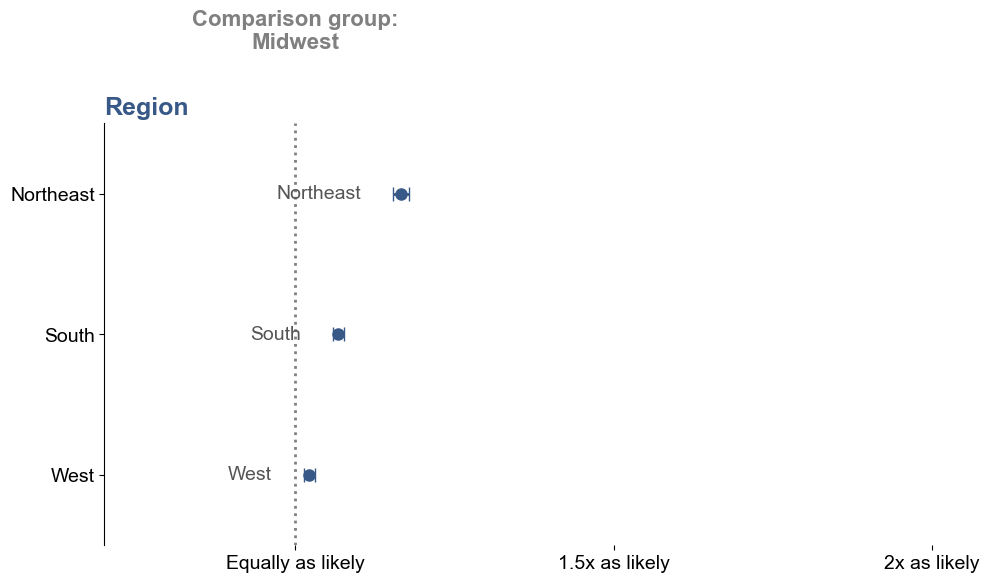

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

region_graph_data = {
    'group': ['Intercept','Northeast', 'South', 'West'],
    'odds_ratio': odds_ratios_regions,
    'lower_ci': conf_int_regions[0],
    'upper_ci': conf_int_regions[1]
}
region_graph_df = pd.DataFrame(region_graph_data)
region_graph_df = region_graph_df[region_graph_df['group'] != 'Intercept']
region_graph_df = region_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=region_graph_df['odds_ratio'],
    y=region_graph_df.index,
    xerr=[region_graph_df['odds_ratio'] - region_graph_df['lower_ci'], region_graph_df['upper_ci'] - region_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(region_graph_df.index)
ax.set_yticklabels(region_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(region_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = region_graph_df['lower_ci'].iloc[i] - 0.05
    # y-position for the text: same as the point's position
    y_pos = region_graph_df.index[i]
    # The text itself
    label = region_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=14, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Region', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(1, len(region_graph_df), 'Comparison group:\nMidwest', ha='center', va='bottom', fontsize=16, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(region_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)

# Set axis limits
ax.set_xlim(0.7, 2)
ax.set_ylim(-0.5, len(region_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.show()


#### model and graph for distance group

In [70]:
model_logit_distance = smf.logit("ArrDel15 ~ C(DistanceGroup)", data=train2).fit()
model_logit_distance.summary()

Optimization terminated successfully.
         Current function value: 0.534847
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:              3313906
Model:                          Logit   Df Residuals:                  3313895
Method:                           MLE   Df Model:                           10
Date:                Sat, 26 Jul 2025   Pseudo R-squ.:                0.001162
Time:                        21:41:48   Log-Likelihood:            -1.7724e+06
converged:                       True   LL-Null:                   -1.7745e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.2764      0.005   -277.304      0.000      -1.285      -1.267
C(DistanceGroup)[T.2]     -0.0520      0.006     -9.357      0.000      -0.063      -0.041
C(DistanceGroup)[T.3]      0.0106      0.006      1.903      0.057      -0.000       0.021
C(DistanceGroup)[T.4]      0.1099      0.005     19.994      0.000       0.099       0.121
C(DistanceGroup)[T.5]      0.2088      0.006     36.534      0.000       0.198       0.220
C(DistanceGroup)[T.6]      0.0352      0.007      4.888      0.000       0.021       0.049
C(DistanceGroup)[T.7]      0.0815      0.007     11.266      0.000       0.067       0.096
C(DistanceGroup)[T.8]     -0.0386      0.009     -4.099      0.000      -0.057      -0.020
C(DistanceGroup)[T.9]      0.0484      0.010      4.677      0.000       0.028       0.069
C(DistanceGroup)[T.10]     0.0174      0.008      2.069      0.039       0.001       0.034
C(DistanceGroup)[T.11]     0.0074      0.009      0.806      0.420      -0.011       0.025
==========================================================================================
"""

In [71]:
odds_ratios_distance = model_logit_distance.params.apply(lambda x: np.exp(x))
conf_int_distance = model_logit_distance.conf_int().apply(lambda x: np.exp(x))

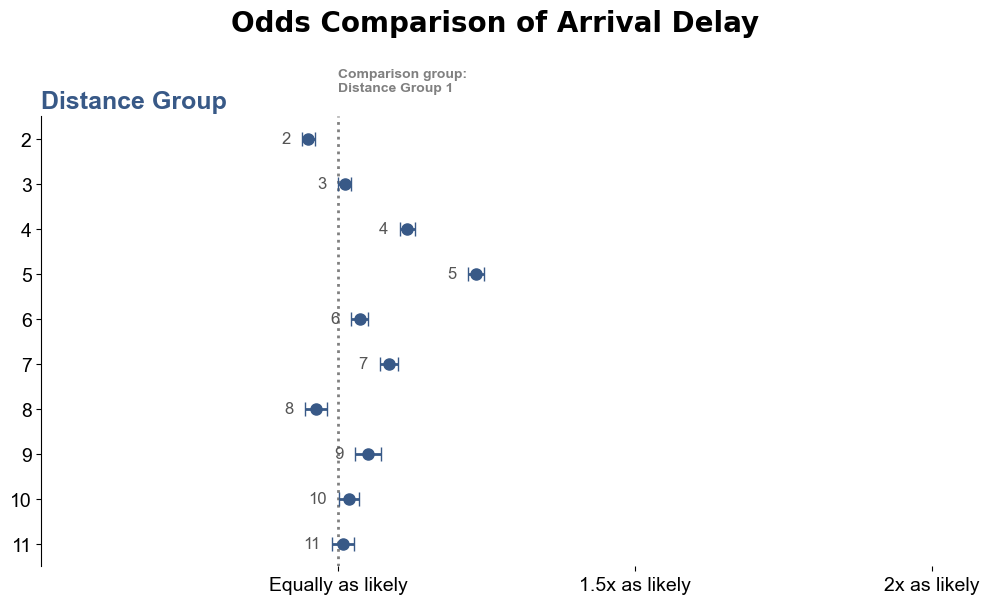

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

distance_graph_data = {
    'group': ['Intercept','2','3','4','5','6','7','8','9','10','11'],
    'odds_ratio': odds_ratios_distance,
    'lower_ci': conf_int_distance[0],
    'upper_ci': conf_int_distance[1]
}
distance_graph_df = pd.DataFrame(distance_graph_data)
distance_graph_df = distance_graph_df[distance_graph_df['group'] != 'Intercept']
distance_graph_df = distance_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=distance_graph_df['odds_ratio'],
    y=distance_graph_df.index,
    xerr=[distance_graph_df['odds_ratio'] - distance_graph_df['lower_ci'], distance_graph_df['upper_ci'] - distance_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(distance_graph_df.index)
ax.set_yticklabels(distance_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(distance_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = distance_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = distance_graph_df.index[i]
    # The text itself
    label = distance_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Distance Group', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(1, len(distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(distance_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.show()


#### JetBlue region

In [3]:
train_b6 = train2[train2["Operating_Airline"]=="B6"]
model_logit_b6_region = smf.logit("ArrDel15 ~ C(Region)", data=train_b6).fit()
model_logit_b6_region.summary()

Optimization terminated successfully.
         Current function value: 0.619141
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               179854
Model:                          Logit   Df Residuals:                   179850
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:               0.0007330
Time:                        10:34:36   Log-Likelihood:            -1.1135e+05
converged:                       True   LL-Null:                   -1.1144e+05
Covariance Type:            nonrobust   LLR p-value:                 3.425e-35
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.9298      0.034    -27.658      0.000      -0.996      -0.864
C(Region)[T.Northeast]     0.1032      0.034      3.002      0.003       0.036       0.171
C(Region)[T.South]         0.2148      0.035      6.193      0.000       0.147       0.283
C(Region)[T.West]          0.0362      0.037      0.977      0.329      -0.036       0.109
==========================================================================================
"""

In [4]:
odds_ratio = np.exp(model_logit_b6_region.params)
print(odds_ratio)

Intercept                 0.394627
C(Region)[T.Northeast]    1.108665
C(Region)[T.South]        1.239655
C(Region)[T.West]         1.036871
dtype: float64


#### Jet Blue distance

In [16]:
train_b6 = train2[train2["Operating_Airline"]=="B6"]
model_logit_b6 = smf.logit("ArrDel15 ~ C(DistanceGroup) + C(Is_Holiday_Week) + C(DayOfWeek) + C(hour_of_day) + C(Region) + C(Size_Class)", data=train_b6).fit()
model_logit_b6.summary()

         Current function value: 0.562175
         Iterations: 35


c:\ProgramData\anaconda3\envs\hannah_environment\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               179854
Model:                          Logit   Df Residuals:                   179807
Method:                           MLE   Df Model:                           46
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                 0.09267
Time:                        09:31:41   Log-Likelihood:            -1.0111e+05
converged:                      False   LL-Null:                   -1.1144e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.8467      0.157     18.184      0.000       2.540       3.154
C(DistanceGroup)[T.2]          -0.0654      0.026     -2.565      0.010      -0.115      -0.015
C(DistanceGroup)[T.3]           0.2617      0.028      9.218      0.000       0.206       0.317
C(DistanceGroup)[T.4]           0.4046      0.025     16.341      0.000       0.356       0.453
C(DistanceGroup)[T.5]           0.3872      0.023     16.839      0.000       0.342       0.432
C(DistanceGroup)[T.6]           0.4038      0.047      8.628      0.000       0.312       0.496
C(DistanceGroup)[T.7]           0.3604      0.031     11.453      0.000       0.299       0.422
C(DistanceGroup)[T.8]           0.2505      0.045      5.549      0.000       0.162       0.339
C(DistanceGroup)[T.9]           0.2635      0.040      6.633      0.000       0.186       0.341
C(DistanceGroup)[T.10]          0.0349      0.029      1.199      0.231      -0.022       0.092
C(DistanceGroup)[T.11]         -0.1917      0.032     -5.900      0.000      -0.255      -0.128
C(Is_Holiday_Week)[T.True]      0.0726      0.013      5.546      0.000       0.047       0.098
C(DayOfWeek)[T.2]              -0.2951      0.020    -14.549      0.000      -0.335      -0.255
C(DayOfWeek)[T.3]              -0.2944      0.020    -14.488      0.000      -0.334      -0.255
C(DayOfWeek)[T.4]              -0.0350      0.020     -1.773      0.076      -0.074       0.004
C(DayOfWeek)[T.5]               0.0230      0.020      1.181      0.238      -0.015       0.061
C(DayOfWeek)[T.6]              -0.0513      0.021     -2.488      0.013      -0.092      -0.011
C(DayOfWeek)[T.7]               0.0916      0.020      4.670      0.000       0.053       0.130
C(hour_of_day)[T.2.0]          12.4832    133.497      0.094      0.925    -249.166     274.132
C(hour_of_day)[T.3.0]          19.9862   1.04e+04      0.002      0.998   -2.04e+04    2.04e+04
C(hour_of_day)[T.4.0]          -5.0351      0.242    -20.834      0.000      -5.509      -4.561
C(hour_of_day)[T.5.0]          -5.6664      0.159    -35.694      0.000      -5.978      -5.355
C(hour_of_day)[T.6.0]          -5.3153      0.153    -34.784      0.000      -5.615      -5.016
C(hour_of_day)[T.7.0]          -4.8786      0.152    -32.035      0.000      -5.177      -4.580
C(hour_of_day)[T.8.0]          -4.5370      0.152    -29.807      0.000      -4.835      -4.239
C(hour_of_day)[T.9.0]          -4.5677      0.152    -30.025      0.000      -4.866      -4.270
C(hour_of_day)[T.10.0]         -4.3729      0.152    -28.846      0.000      -4.670      -4.076
C(hour_of_day)[T.11.0]         -4.0745      0.152    -26.889      0.000      -4.371      -3.777
C(hour_of_day)[T.12.0]         -3.9652      0.152    -26.140      0.000      -4.263      -3.668
C(hour_of_day)[T.13.0]         -3.9023      0.152    -25.751      0.000      -4.199      -3.605
C(hour_of_day)[T.14.0]         -3.7127      0.151    -24.521      0.000  

In [30]:
train_b6 = train2[train2["Operating_Airline"]=="B6"]
model_logit_b6_distance = smf.logit("ArrDel15 ~ C(DistanceGroup)", data=train_b6).fit()
model_logit_b6_distance.summary()

Optimization terminated successfully.
         Current function value: 0.615785
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               179854
Model:                          Logit   Df Residuals:                   179843
Method:                           MLE   Df Model:                           10
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                0.006149
Time:                        10:10:58   Log-Likelihood:            -1.1075e+05
converged:                       True   LL-Null:                   -1.1144e+05
Covariance Type:            nonrobust   LLR p-value:                2.394e-288
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.9995      0.018    -55.418      0.000      -1.035      -0.964
C(DistanceGroup)[T.2]     -0.0894      0.024     -3.804      0.000      -0.136      -0.043
C(DistanceGroup)[T.3]      0.1465      0.025      5.786      0.000       0.097       0.196
C(DistanceGroup)[T.4]      0.3593      0.022     16.459      0.000       0.317       0.402
C(DistanceGroup)[T.5]      0.3293      0.020     16.234      0.000       0.290       0.369
C(DistanceGroup)[T.6]      0.2463      0.044      5.641      0.000       0.161       0.332
C(DistanceGroup)[T.7]      0.3528      0.029     12.202      0.000       0.296       0.409
C(DistanceGroup)[T.8]      0.3992      0.042      9.606      0.000       0.318       0.481
C(DistanceGroup)[T.9]      0.5066      0.036     14.250      0.000       0.437       0.576
C(DistanceGroup)[T.10]     0.1441      0.025      5.654      0.000       0.094       0.194
C(DistanceGroup)[T.11]    -0.1885      0.029     -6.502      0.000      -0.245      -0.132
==========================================================================================
"""

In [114]:
odds_ratio = np.exp(model_logit_b6_distance.params)
print(odds_ratio)

Intercept                 0.368076
C(DistanceGroup)[T.2]     0.914439
C(DistanceGroup)[T.3]     1.157797
C(DistanceGroup)[T.4]     1.432355
C(DistanceGroup)[T.5]     1.390033
C(DistanceGroup)[T.6]     1.279319
C(DistanceGroup)[T.7]     1.423035
C(DistanceGroup)[T.8]     1.490616
C(DistanceGroup)[T.9]     1.659696
C(DistanceGroup)[T.10]    1.154976
C(DistanceGroup)[T.11]    0.828199
dtype: float64


In [ ]:
from sklearn.metrics import classification_report

y_pred_prob_b6 = model_logit_b6.predict(train_b6)

y_pred_class_b6 = (y_pred_prob_b6 > 0.2292).astype(int)

# 3. Get the true (actual) values from your dataset
y_true_b6 = train_b6['ArrDel15']

report_b6 = classification_report(y_true_b6, y_pred_class_b6)
print(report_b6)

              precision    recall  f1-score   support

         0.0       0.86      0.57      0.68   2288057
         1.0       0.32      0.68      0.43    679685

    accuracy                           0.59   2967742
   macro avg       0.59      0.62      0.56   2967742
weighted avg       0.73      0.59      0.62   2967742



In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import sklearn
y_true_b6_distance = train_b6['ArrDel15']
y_pred_prob_b6_distance = model_logit_b6_distance.predict(train_b6)

# --- 4. Calculate AUC-ROC ---
auc_roc = roc_auc_score(y_true_b6_distance, y_pred_prob_b6_distance)
print(f"Concordance for Logistic Regression: {auc_roc:.4f}")

Concordance for Logistic Regression: 0.5506


In [ ]:
odds_ratio_b6_distance = 100*(np.exp(model_logit_b6_distance.params) - 1)
import pandas as pd
pd.set_option('display.max_rows', None) 

print(odds_ratio_b6_distance)

Intercept                -63.192439
C(DistanceGroup)[T.2]     -8.556134
C(DistanceGroup)[T.3]     15.779677
C(DistanceGroup)[T.4]     43.235460
C(DistanceGroup)[T.5]     39.003346
C(DistanceGroup)[T.6]     27.931888
C(DistanceGroup)[T.7]     42.303492
C(DistanceGroup)[T.8]     49.061597
C(DistanceGroup)[T.9]     65.969583
C(DistanceGroup)[T.10]    15.497584
C(DistanceGroup)[T.11]   -17.180094
dtype: float64


In [ ]:
odds_ratio_b6_distance = np.exp(model_logit_b6_distance.params)
import pandas as pd
pd.set_option('display.max_rows', None) 

print(odds_ratio_b6_distance)

Intercept                 0.368076
C(DistanceGroup)[T.2]     0.914439
C(DistanceGroup)[T.3]     1.157797
C(DistanceGroup)[T.4]     1.432355
C(DistanceGroup)[T.5]     1.390033
C(DistanceGroup)[T.6]     1.279319
C(DistanceGroup)[T.7]     1.423035
C(DistanceGroup)[T.8]     1.490616
C(DistanceGroup)[T.9]     1.659696
C(DistanceGroup)[T.10]    1.154976
C(DistanceGroup)[T.11]    0.828199
dtype: float64


In [31]:
odds_ratios_b6_distance = model_logit_b6_distance.params.apply(lambda x: np.exp(x))
conf_int_b6_distance = model_logit_b6_distance.conf_int().apply(lambda x: np.exp(x))

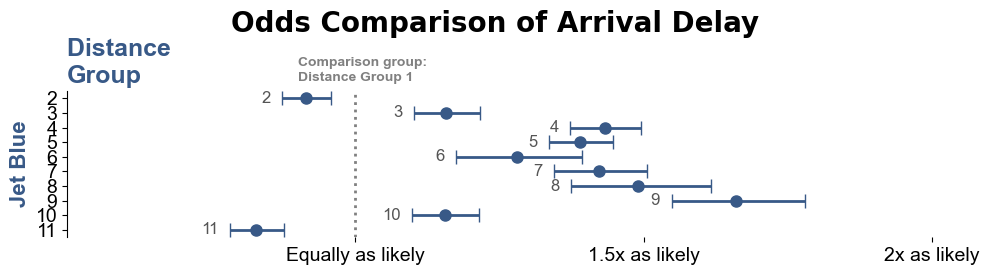

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

b6_distance_data = {
    'group': ['Intercept','2','3','4','5','6','7','8','9','10','11'],
    'odds_ratio': odds_ratios_b6_distance,
    'lower_ci': conf_int_b6_distance[0],
    'upper_ci': conf_int_b6_distance[1]
}
b6_distance_graph_df = pd.DataFrame(b6_distance_data)
b6_distance_graph_df = b6_distance_graph_df[b6_distance_graph_df['group'] != 'Intercept']
b6_distance_graph_df = b6_distance_graph_df.iloc[::-1].reset_index(drop=True)

#########
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=b6_distance_graph_df['odds_ratio'],
    y=b6_distance_graph_df.index,
    xerr=[b6_distance_graph_df['odds_ratio'] - b6_distance_graph_df['lower_ci'], b6_distance_graph_df['upper_ci'] - b6_distance_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(b6_distance_graph_df.index)
ax.set_yticklabels(b6_distance_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(b6_distance_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = b6_distance_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = b6_distance_graph_df.index[i]
    # The text itself
    label = b6_distance_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Distance \nGroup', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(.9, len(b6_distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(b6_distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=0.9)
ax.set_ylabel("Jet Blue", fontsize=16, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(b6_distance_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/b6_distance')
plt.show()


#### jet blue size class

In [71]:
train_b6 = train2[train2["Operating_Airline"]=="B6"]
model_logit_b6_size = smf.logit("ArrDel15 ~ C(Size_Class, Treatment('Non Hub'))", data=train_b6).fit()
model_logit_b6_size.summary()

Optimization terminated successfully.
         Current function value: 0.619369
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               179854
Model:                          Logit   Df Residuals:                   179850
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:               0.0003646
Time:                        11:38:10   Log-Likelihood:            -1.1140e+05
converged:                       True   LL-Null:                   -1.1144e+05
Covariance Type:            nonrobust   LLR p-value:                 1.640e-17
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -1.0072      0.053    -18.906      0.000      -1.112      -0.903
C(Size_Class, Treatment('Non Hub'))[T.Large Hub]      0.2217      0.054      4.138      0.000       0.117       0.327
C(Size_Class, Treatment('Non Hub'))[T.Medium Hub]     0.2225      0.055      4.044      0.000       0.115       0.330
C(Size_Class, Treatment('Non Hub'))[T.Small Hub]      0.0354      0.058      0.610      0.542      -0.078       0.149
=====================================================================================================================
"""

In [73]:
odds_ratios_b6_size = model_logit_b6_size.params.apply(lambda x: np.exp(x))
conf_int_b6_size = model_logit_b6_size.conf_int().apply(lambda x: np.exp(x))

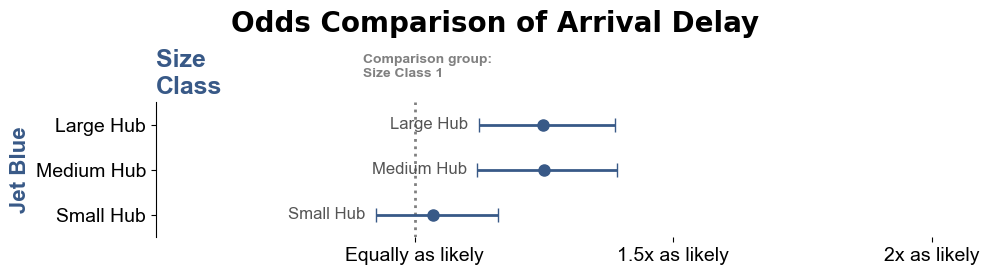

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

b6_size_data = {
    'group': ['Intercept','Large Hub', 'Medium Hub', 'Small Hub'],
    'odds_ratio': odds_ratios_b6_size,
    'lower_ci': conf_int_b6_size[0],
    'upper_ci': conf_int_b6_size[1]
}
b6_size_graph_df = pd.DataFrame(b6_size_data)
b6_size_graph_df = b6_size_graph_df[b6_size_graph_df['group'] != 'Intercept']
b6_size_graph_df = b6_size_graph_df.iloc[::-1].reset_index(drop=True)

#########
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=b6_size_graph_df['odds_ratio'],
    y=b6_size_graph_df.index,
    xerr=[b6_size_graph_df['odds_ratio'] - b6_size_graph_df['lower_ci'], b6_size_graph_df['upper_ci'] - b6_size_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(b6_size_graph_df.index)
ax.set_yticklabels(b6_size_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(b6_size_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = b6_size_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = b6_size_graph_df.index[i]
    # The text itself
    label = b6_size_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
ax.set_title('Size \nClass', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
ax.text(.9, len(b6_size_graph_df), 'Comparison group:\nSize Class 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
ax.text(2.3, len(b6_size_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=0.9)
ax.set_ylabel("Jet Blue", fontsize=16, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(b6_size_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
#plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/b6_size')
plt.show()

#### jet blue hour

In [80]:
train_b6 = train2[train2["Operating_Airline"]=="F9"]
model_logit_b6_hour = smf.logit("ArrDel15 ~ C(hour_group, Treatment('Morning'))", data=train_b6).fit()
model_logit_b6_hour.summary()

Optimization terminated successfully.
         Current function value: 0.601591
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                98068
Model:                          Logit   Df Residuals:                    98064
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                 0.03076
Time:                        14:19:23   Log-Likelihood:                -58997.
converged:                       True   LL-Null:                       -60869.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -1.3241      0.013    -98.394      0.000      -1.350      -1.298
C(hour_group, Treatment('Morning'))[T.Afternoon]         0.6476      0.018     36.006      0.000       0.612       0.683
C(hour_group, Treatment('Morning'))[T.Early Morning]     0.0663      0.033      2.015      0.044       0.002       0.131
C(hour_group, Treatment('Morning'))[T.Night]             1.0434      0.018     57.215      0.000       1.008       1.079
========================================================================================================================
"""

In [78]:
odds_ratio = np.exp(model_logit_b6_hour.params)
print(odds_ratio)

Intercept                                                 0.284263
C(hour_group, Treatment('Early Morning'))[T.Afternoon]    1.788484
C(hour_group, Treatment('Early Morning'))[T.Morning]      0.935894
C(hour_group, Treatment('Early Morning'))[T.Night]        2.656978
dtype: float64


In [81]:
odds_ratio_percent = 100*(np.exp(model_logit_b6_hour.params) - 1)
print(odds_ratio_percent)

Intercept                                               -73.395997
C(hour_group, Treatment('Morning'))[T.Afternoon]         91.098958
C(hour_group, Treatment('Morning'))[T.Early Morning]      6.849689
C(hour_group, Treatment('Morning'))[T.Night]            183.897240
dtype: float64


#### jetblue hour range

#### frontier region

In [9]:
train_f9 = train2[train2["Operating_Airline"]=="F9"]
model_logit_f9_region = smf.logit("ArrDel15 ~ C(Region, Treatment('West'))", data=train_f9).fit()
model_logit_f9_region.summary()

Optimization terminated successfully.
         Current function value: 0.621382
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               103663
Model:                          Logit   Df Residuals:                   103659
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                0.001887
Time:                        11:01:27   Log-Likelihood:                -64414.
converged:                       True   LL-Null:                       -64536.
Covariance Type:            nonrobust   LLR p-value:                 1.660e-52
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.9176      0.011    -80.018      0.000      -0.940      -0.895
C(Region, Treatment('West'))[T.Midwest]       0.1474      0.024      6.138      0.000       0.100       0.194
C(Region, Treatment('West'))[T.Northeast]     0.1904      0.022      8.729      0.000       0.148       0.233
C(Region, Treatment('West'))[T.South]         0.2345      0.015     15.250      0.000       0.204       0.265
=============================================================================================================
"""

In [10]:
odds_ratio = np.exp(model_logit_f9_region.params)
print(odds_ratio)

Intercept                                    0.399474
C(Region, Treatment('West'))[T.Midwest]      1.158780
C(Region, Treatment('West'))[T.Northeast]    1.209694
C(Region, Treatment('West'))[T.South]        1.264245
dtype: float64


#### frontier distance

In [20]:
train_f9 = train2[train2["Operating_Airline"]=="F9"]
model_logit_f9_distance = smf.logit("ArrDel15 ~ C(DistanceGroup)", data=train_f9).fit()
model_logit_f9_distance.summary()

Optimization terminated successfully.
         Current function value: 0.620673
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               103663
Model:                          Logit   Df Residuals:                   103653
Method:                           MLE   Df Model:                            9
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                0.003026
Time:                        09:37:18   Log-Likelihood:                -64341.
converged:                       True   LL-Null:                       -64536.
Covariance Type:            nonrobust   LLR p-value:                 1.448e-78
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.7904      0.044    -18.060      0.000      -0.876      -0.705
C(DistanceGroup)[T.2]     -0.1190      0.048     -2.475      0.013      -0.213      -0.025
C(DistanceGroup)[T.3]      0.0031      0.047      0.067      0.946      -0.088       0.095
C(DistanceGroup)[T.4]      0.0285      0.045      0.627      0.531      -0.061       0.118
C(DistanceGroup)[T.5]      0.0179      0.046      0.387      0.699      -0.073       0.109
C(DistanceGroup)[T.6]     -0.3273      0.052     -6.303      0.000      -0.429      -0.226
C(DistanceGroup)[T.7]      0.1623      0.049      3.317      0.001       0.066       0.258
C(DistanceGroup)[T.8]      0.1078      0.062      1.728      0.084      -0.014       0.230
C(DistanceGroup)[T.9]      0.4127      0.056      7.323      0.000       0.302       0.523
C(DistanceGroup)[T.10]     0.5051      0.136      3.719      0.000       0.239       0.771
==========================================================================================
"""

In [112]:
odds_ratio = np.exp(model_logit_f9_distance.params)
print(odds_ratio)

Intercept                 0.453676
C(DistanceGroup)[T.2]     0.887816
C(DistanceGroup)[T.3]     1.003153
C(DistanceGroup)[T.4]     1.028937
C(DistanceGroup)[T.5]     1.018079
C(DistanceGroup)[T.6]     0.720870
C(DistanceGroup)[T.7]     1.176193
C(DistanceGroup)[T.8]     1.113786
C(DistanceGroup)[T.9]     1.510945
C(DistanceGroup)[T.10]    1.657070
dtype: float64


In [21]:
odds_ratios_f9_distance = model_logit_f9_distance.params.apply(lambda x: np.exp(x))
conf_int_f9_distance = model_logit_f9_distance.conf_int().apply(lambda x: np.exp(x))

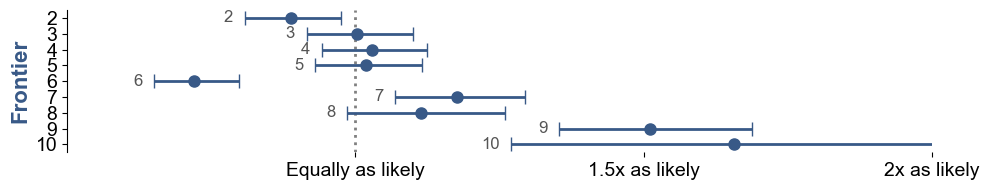

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

f9_distance_data = {
    'group': ['Intercept','2','3','4','5','6','7','8','9','10'],
    'odds_ratio': odds_ratios_f9_distance,
    'lower_ci': conf_int_f9_distance[0],
    'upper_ci': conf_int_f9_distance[1]
}
f9_distance_graph_df = pd.DataFrame(f9_distance_data)
f9_distance_graph_df = f9_distance_graph_df[f9_distance_graph_df['group'] != 'Intercept']
f9_distance_graph_df = f9_distance_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 2))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=f9_distance_graph_df['odds_ratio'],
    y=f9_distance_graph_df.index,
    xerr=[f9_distance_graph_df['odds_ratio'] - f9_distance_graph_df['lower_ci'], f9_distance_graph_df['upper_ci'] - f9_distance_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(f9_distance_graph_df.index)
ax.set_yticklabels(f9_distance_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(f9_distance_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = f9_distance_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = f9_distance_graph_df.index[i]
    # The text itself
    label = f9_distance_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
#ax.set_title('Distance Group', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
#ax.text(1, len(f9_distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
#ax.text(2.3, len(f9_distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
#fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)
ax.set_ylabel("Frontier", fontsize=16, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(f9_distance_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/f9_distance')
plt.show()

#### frontier size

In [75]:
train_f9 = train2[train2["Operating_Airline"]=="F9"]
model_logit_f9_size = smf.logit("ArrDel15 ~ C(Size_Class, Treatment('Non Hub'))", data=train_f9).fit()
model_logit_f9_size.summary()

Optimization terminated successfully.
         Current function value: 0.622544
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               103663
Model:                          Logit   Df Residuals:                   103659
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:               1.977e-05
Time:                        11:43:09   Log-Likelihood:                -64535.
converged:                       True   LL-Null:                       -64536.
Covariance Type:            nonrobust   LLR p-value:                    0.4659
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.8373      0.044    -18.925      0.000      -0.924      -0.751
C(Size_Class, Treatment('Non Hub'))[T.Large Hub]      0.0622      0.045      1.385      0.166      -0.026       0.150
C(Size_Class, Treatment('Non Hub'))[T.Medium Hub]     0.0485      0.047      1.031      0.303      -0.044       0.141
C(Size_Class, Treatment('Non Hub'))[T.Small Hub]      0.0451      0.054      0.843      0.399      -0.060       0.150
=====================================================================================================================
"""

In [76]:
odds_ratios_f9_size = model_logit_f9_size.params.apply(lambda x: np.exp(x))
conf_int_f9_size = model_logit_f9_size.conf_int().apply(lambda x: np.exp(x))

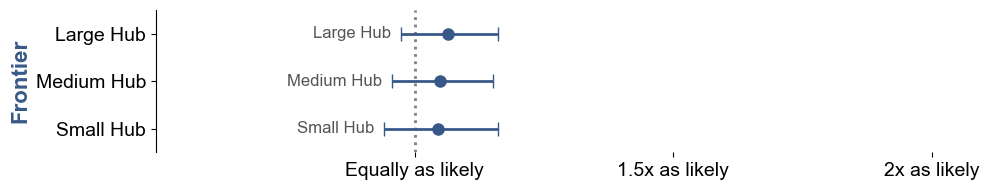

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

f9_size_data = {
    'group': ['Intercept','Large Hub', 'Medium Hub', 'Small Hub'],
    'odds_ratio': odds_ratios_f9_size,
    'lower_ci': conf_int_f9_size[0],
    'upper_ci': conf_int_f9_size[1]
}
f9_size_graph_df = pd.DataFrame(f9_size_data)
f9_size_graph_df = f9_size_graph_df[f9_size_graph_df['group'] != 'Intercept']
f9_size_graph_df = f9_size_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 2))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=f9_size_graph_df['odds_ratio'],
    y=f9_size_graph_df.index,
    xerr=[f9_size_graph_df['odds_ratio'] - f9_size_graph_df['lower_ci'], f9_size_graph_df['upper_ci'] - f9_size_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(f9_size_graph_df.index)
ax.set_yticklabels(f9_size_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(f9_size_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = f9_size_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = f9_size_graph_df.index[i]
    # The text itself
    label = f9_size_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
#ax.set_title('Distance Group', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
#ax.text(1, len(f9_distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
#ax.text(2.3, len(f9_distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
#fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)
ax.set_ylabel("Frontier", fontsize=16, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(f9_size_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
#plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/f9_size')
plt.show()

#### allegiant region

In [14]:
train_g4 = train2[train2["Operating_Airline"]=="G4"]
model_logit_g4_region = smf.logit("ArrDel15 ~ C(Region, Treatment('South'))", data=train_g4).fit()
model_logit_g4_region.summary()

Optimization terminated successfully.
         Current function value: 0.632678
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                78177
Model:                          Logit   Df Residuals:                    78173
Method:                           MLE   Df Model:                            3
Date:                Tue, 29 Jul 2025   Pseudo R-squ.:               0.0005812
Time:                        16:35:08   Log-Likelihood:                -49461.
converged:                       True   LL-Null:                       -49490.
Covariance Type:            nonrobust   LLR p-value:                 1.984e-12
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -0.7681      0.011    -70.302      0.000      -0.789      -0.747
C(Region, Treatment('South'))[T.Midwest]       0.1439      0.020      7.147      0.000       0.104       0.183
C(Region, Treatment('South'))[T.Northeast]     0.0427      0.030      1.443      0.149      -0.015       0.101
C(Region, Treatment('South'))[T.West]          0.0886      0.019      4.622      0.000       0.051       0.126
==============================================================================================================
"""

In [15]:
odds_ratio = np.exp(model_logit_g4_region.params)
print(odds_ratio)

Intercept                                     0.463916
C(Region, Treatment('South'))[T.Midwest]      1.154767
C(Region, Treatment('South'))[T.Northeast]    1.043669
C(Region, Treatment('South'))[T.West]         1.092606
dtype: float64


#### allegiant distance

In [32]:
train_g4 = train2[train2["Operating_Airline"]=="G4"]
model_logit_g4_distance = smf.logit("ArrDel15 ~ C(DistanceGroup, Treatment(9))", data=train_g4).fit()
model_logit_g4_distance.summary()

Optimization terminated successfully.
         Current function value: 0.632045
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                78177
Model:                          Logit   Df Residuals:                    78168
Method:                           MLE   Df Model:                            8
Date:                Tue, 29 Jul 2025   Pseudo R-squ.:                0.001581
Time:                        19:21:46   Log-Likelihood:                -49411.
converged:                       True   LL-Null:                       -49490.
Covariance Type:            nonrobust   LLR p-value:                 8.710e-30
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.4012      1.017     -3.346      0.001      -5.394      -1.409
C(DistanceGroup, Treatment(9))[T.1]     2.7506      1.024      2.685      0.007       0.743       4.758
C(DistanceGroup, Treatment(9))[T.2]     2.8231      1.017      2.776      0.005       0.830       4.816
C(DistanceGroup, Treatment(9))[T.3]     2.7838      1.017      2.738      0.006       0.791       4.776
C(DistanceGroup, Treatment(9))[T.4]     2.6240      1.017      2.581      0.010       0.631       4.617
C(DistanceGroup, Treatment(9))[T.5]     2.5954      1.017      2.553      0.011       0.603       4.588
C(DistanceGroup, Treatment(9))[T.6]     2.6588      1.017      2.615      0.009       0.666       4.652
C(DistanceGroup, Treatment(9))[T.7]     2.7099      1.017      2.664      0.008       0.716       4.704
C(DistanceGroup, Treatment(9))[T.8]     2.9754      1.020      2.916      0.004       0.976       4.975
=======================================================================================================
"""

In [111]:
odds_ratio = np.exp(model_logit_g4_distance.params)
print(odds_ratio)

Intercept                0.521739
C(DistanceGroup)[T.2]    1.075177
C(DistanceGroup)[T.3]    1.033773
C(DistanceGroup)[T.4]    0.881098
C(DistanceGroup)[T.5]    0.856257
C(DistanceGroup)[T.6]    0.912308
C(DistanceGroup)[T.7]    0.960098
C(DistanceGroup)[T.8]    1.252064
C(DistanceGroup)[T.9]    0.063889
dtype: float64


In [34]:
odds_ratio_percent = 100*(np.exp(model_logit_g4_distance.params) - 1)
print(odds_ratio_percent)

Intercept                               -96.666667
C(DistanceGroup, Treatment(9))[T.1]    1465.217391
C(DistanceGroup, Treatment(9))[T.2]    1582.885271
C(DistanceGroup, Treatment(9))[T.3]    1518.078719
C(DistanceGroup, Treatment(9))[T.4]    1279.109633
C(DistanceGroup, Treatment(9))[T.5]    1240.227748
C(DistanceGroup, Treatment(9))[T.6]    1327.960774
C(DistanceGroup, Treatment(9))[T.7]    1402.762431
C(DistanceGroup, Treatment(9))[T.8]    1859.752322
dtype: float64


In [36]:
odds_ratios_g4_distance = model_logit_g4_distance.params.apply(lambda x: np.exp(x))
conf_int_g4_distance = model_logit_g4_distance.conf_int().apply(lambda x: np.exp(x))

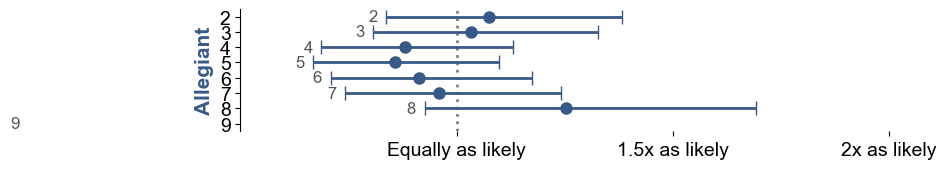

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

g4_distance_data = {
    'group': ['Intercept','2','3','4','5','6','7','8','9'],
    'odds_ratio': odds_ratios_g4_distance,
    'lower_ci': conf_int_g4_distance[0],
    'upper_ci': conf_int_g4_distance[1]
}
g4_distance_graph_df = pd.DataFrame(g4_distance_data)
g4_distance_graph_df = g4_distance_graph_df[g4_distance_graph_df['group'] != 'Intercept']
g4_distance_graph_df = g4_distance_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 1.8))
#fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=g4_distance_graph_df['odds_ratio'],
    y=g4_distance_graph_df.index,
    xerr=[g4_distance_graph_df['odds_ratio'] - g4_distance_graph_df['lower_ci'], g4_distance_graph_df['upper_ci'] - g4_distance_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(g4_distance_graph_df.index)
ax.set_yticklabels(g4_distance_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(g4_distance_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = g4_distance_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = g4_distance_graph_df.index[i]
    # The text itself
    label = g4_distance_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
#ax.set_title('Distance Group', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
#ax.text(1, len(g4_distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
#ax.text(2.3, len(g4_distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
#fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)
ax.set_ylabel("Allegiant", fontsize=15, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(g4_distance_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/g4_distance')
plt.show()

#### allegiant size

In [13]:
train_g4 = train2[train2["Operating_Airline"]=="G4"]
model_logit_g4_size = smf.logit("ArrDel15 ~ C(Size_Class, Treatment('Large Hub'))", data=train_g4).fit()
model_logit_g4_size.summary()

Optimization terminated successfully.
         Current function value: 0.631223
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                78177
Model:                          Logit   Df Residuals:                    78173
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                0.002880
Time:                        11:08:15   Log-Likelihood:                -49347.
converged:                       True   LL-Null:                       -49490.
Covariance Type:            nonrobust   LLR p-value:                 1.740e-61
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -0.6880      0.017    -39.605      0.000      -0.722      -0.654
C(Size_Class, Treatment('Large Hub'))[T.Medium Hub]     0.0201      0.027      0.740      0.459      -0.033       0.073
C(Size_Class, Treatment('Large Hub'))[T.Non Hub]        0.1622      0.023      6.998      0.000       0.117       0.208
C(Size_Class, Treatment('Large Hub'))[T.Small Hub]     -0.1583      0.021     -7.560      0.000      -0.199      -0.117
=======================================================================================================================
"""

In [14]:
odds_ratio = np.exp(model_logit_g4_size.params)
print(odds_ratio)

Intercept                                              0.502574
C(Size_Class, Treatment('Large Hub'))[T.Medium Hub]    1.020268
C(Size_Class, Treatment('Large Hub'))[T.Non Hub]       1.176146
C(Size_Class, Treatment('Large Hub'))[T.Small Hub]     0.853581
dtype: float64


In [82]:
odds_ratios_g4_size = model_logit_g4_size.params.apply(lambda x: np.exp(x))
conf_int_g4_size = model_logit_g4_size.conf_int().apply(lambda x: np.exp(x))

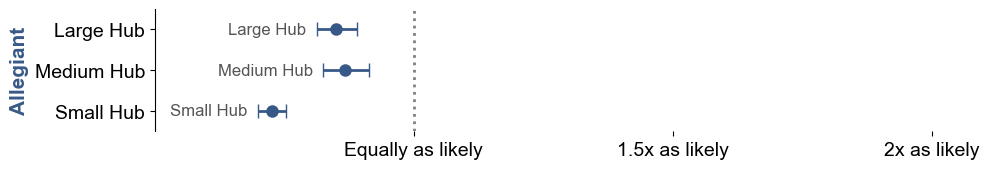

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

g4_size_data = {
    'group': ['Intercept','Large Hub', 'Medium Hub', 'Small Hub'],
    'odds_ratio': odds_ratios_g4_size,
    'lower_ci': conf_int_g4_size[0],
    'upper_ci': conf_int_g4_size[1]
}
g4_size_graph_df = pd.DataFrame(g4_size_data)
g4_size_graph_df = g4_size_graph_df[g4_size_graph_df['group'] != 'Intercept']
g4_size_graph_df = g4_size_graph_df.iloc[::-1].reset_index(drop=True)

#########
fig, ax = plt.subplots(figsize=(10, 1.8))
#fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and styles
point_color = '#385987'
line_color = '#385987'
reference_color = '#808080'
font_family = 'Arial'

# Plot the odds ratios and confidence intervals
# The `xerr` parameter takes the difference between the point estimate and the CI bounds
ax.errorbar(
    x=g4_size_graph_df['odds_ratio'],
    y=g4_size_graph_df.index,
    xerr=[g4_size_graph_df['odds_ratio'] - g4_size_graph_df['lower_ci'], g4_size_graph_df['upper_ci'] - g4_size_graph_df['odds_ratio']],
    fmt='o',  # 'o' for dots
    color=point_color,
    ecolor=line_color,
    capsize=5,
    elinewidth=2,
    markersize=8,
    zorder=2  # Ensure the points are on top
)

# Add a vertical line for the reference value (Odds Ratio = 1)
ax.axvline(x=1, color=reference_color, linestyle=':', linewidth=2, zorder=1)

# Set the labels for the y-axis
ax.set_yticks(g4_size_graph_df.index)
ax.set_yticklabels(g4_size_graph_df['group'], fontsize=14, fontfamily=font_family)


#for the labels on each point
for i in range(len(g4_size_graph_df)):
    # x-position for the text: slightly to the left of the point
    x_pos = g4_size_graph_df['lower_ci'].iloc[i] - 0.02
    # y-position for the text: same as the point's position
    y_pos = g4_size_graph_df.index[i]
    # The text itself
    label = g4_size_graph_df['group'].iloc[i]
    
    # Place the text on the plot
    ax.text(x=x_pos, 
            y=y_pos, 
            s=label, 
            ha='right',  # Align the text to the right, so it's flush with the point
            va='center', # Vertically center the text
            fontsize=12, 
            fontfamily=font_family, 
            color='#555555')



# Customize the x-axis ticks and labels
x_ticks = [1, 1.5, 2]
x_labels = ['Equally as likely', '1.5x as likely', '2x as likely']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=14, fontfamily=font_family)

# Remove the spines (top, right, and bottom)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
#ax.set_title('Distance Group', loc='left', fontsize=18, fontweight='bold', fontfamily=font_family, color=point_color)
#ax.text(1, len(g4_distance_graph_df), 'Comparison group:\nDistance Group 1', ha='left', va='bottom', fontsize=10, fontweight='bold', fontfamily=font_family, color=reference_color)
#ax.text(2.3, len(g4_distance_graph_df) - 1, '', ha='right', va='bottom', fontsize=12, fontfamily=font_family)
#fig.suptitle('Odds Comparison of Arrival Delay', fontsize=20, fontweight='bold', ha='center', y=1.0)
ax.set_ylabel("Allegiant", fontsize=15, fontweight='bold', fontfamily=font_family, color=point_color)

# Set axis limits
ax.set_xlim(0.5, 2)
ax.set_ylim(-0.5, len(g4_size_graph_df) - 0.5)

# Tweak the layout
plt.tight_layout()
#plt.savefig('D:/Summer Practicum/0_Personal_Folders/Hannah Enck/g4_size')
plt.show()

#### holiday

In [85]:
train_b6 = train2[train2["Operating_Airline"]=="B6"]
model_logit_b6_holiday = smf.logit("ArrDel15 ~ C(Is_Holiday_Week)", data=train_b6).fit()
model_logit_b6_holiday.summary()

Optimization terminated successfully.
         Current function value: 0.619481
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               179854
Model:                          Logit   Df Residuals:                   179852
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:               0.0001842
Time:                        14:34:54   Log-Likelihood:            -1.1142e+05
converged:                       True   LL-Null:                   -1.1144e+05
Covariance Type:            nonrobust   LLR p-value:                 1.484e-10
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.8144      0.006   -141.229      0.000      -0.826      -0.803
C(Is_Holiday_Week)[T.True]     0.0792      0.012      6.424      0.000       0.055       0.103
==============================================================================================
"""

In [86]:
odds_ratio = np.exp(model_logit_b6_holiday.params)
print(odds_ratio)

Intercept                     0.44292
C(Is_Holiday_Week)[T.True]    1.08239
dtype: float64


In [91]:
train_f9 = train2[train2["Operating_Airline"]=="F9"]
model_logit_f9_holiday = smf.logit("ArrDel15 ~ C(Is_Holiday_Week)", data=train_f9).fit()
model_logit_f9_holiday.summary()

Optimization terminated successfully.
         Current function value: 0.622543
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:               103663
Model:                          Logit   Df Residuals:                   103661
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:               2.073e-05
Time:                        14:38:18   Log-Likelihood:                -64535.
converged:                       True   LL-Null:                       -64536.
Covariance Type:            nonrobust   LLR p-value:                    0.1019
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.7740      0.008   -102.596      0.000      -0.789      -0.759
C(Is_Holiday_Week)[T.True]    -0.0267      0.016     -1.634      0.102      -0.059       0.005
==============================================================================================
"""

In [92]:
odds_ratio = np.exp(model_logit_f9_holiday.params)
print(odds_ratio)

Intercept                     0.461153
C(Is_Holiday_Week)[T.True]    0.973683
dtype: float64


In [93]:
train_g4 = train2[train2["Operating_Airline"]=="G4"]
model_logit_g4_holiday = smf.logit("ArrDel15 ~ C(Is_Holiday_Week)", data=train_g4).fit()
model_logit_g4_holiday.summary()

Optimization terminated successfully.
         Current function value: 0.633046
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                78177
Model:                          Logit   Df Residuals:                    78175
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:               3.170e-07
Time:                        14:41:08   Log-Likelihood:                -49490.
converged:                       True   LL-Null:                       -49490.
Covariance Type:            nonrobust   LLR p-value:                    0.8594
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.7147      0.009    -82.357      0.000      -0.732      -0.698
C(Is_Holiday_Week)[T.True]    -0.0032      0.018     -0.177      0.859      -0.039       0.032
==============================================================================================
"""

In [94]:
odds_ratio = np.exp(model_logit_g4_holiday.params)
print(odds_ratio)

Intercept                     0.489361
C(Is_Holiday_Week)[T.True]    0.996799
dtype: float64


#### new

In [109]:
train_f9 = train2[train2["Operating_Airline"]=="G4"]
model_logit_size = smf.logit("ArrDel15 ~ C(Size_Class, Treatment('Non Hub'))", data=train_f9).fit()
model_logit_size.summary()

Optimization terminated successfully.
         Current function value: 0.631223
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ArrDel15   No. Observations:                78177
Model:                          Logit   Df Residuals:                    78173
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                0.002880
Time:                        15:14:44   Log-Likelihood:                -49347.
converged:                       True   LL-Null:                       -49490.
Covariance Type:            nonrobust   LLR p-value:                 1.740e-61
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.5258      0.015    -34.240      0.000      -0.556      -0.496
C(Size_Class, Treatment('Non Hub'))[T.Large Hub]     -0.1622      0.023     -6.998      0.000      -0.208      -0.117
C(Size_Class, Treatment('Non Hub'))[T.Medium Hub]    -0.1422      0.026     -5.499      0.000      -0.193      -0.092
C(Size_Class, Treatment('Non Hub'))[T.Small Hub]     -0.3206      0.019    -16.608      0.000      -0.358      -0.283
=====================================================================================================================
"""

In [110]:
odds_ratio = np.exp(model_logit_size.params)
print(odds_ratio)

Intercept                                            0.591100
C(Size_Class, Treatment('Non Hub'))[T.Large Hub]     0.850235
C(Size_Class, Treatment('Non Hub'))[T.Medium Hub]    0.867468
C(Size_Class, Treatment('Non Hub'))[T.Small Hub]     0.725745
dtype: float64
